In [8]:
#importing necessary libraries
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
pd.set_option('display.max_columns', None)  # Show all columns in DataFrame output
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import IsolationForest
from pyod.models.abod import ABOD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv(r'imdb_4.csv')
df.drop(columns = ['canHaveEpisodes'], inplace = True)
df

,startYear,runtimeMinutes,totalCredits,numRegions,ratingCount,castNumber,companiesNumber,writerCredits,directorsCredits,totalNominations,totalMedia,totalReviews,Asia,Africa,Europe,North America,South America,Oceania,Continent Unknown,genre1,genre2,genre3,movie,short,tvEpisode,tvMiniSeries,tvMovie,tvSeries,tvShort,tvSpecial,video,videoGame,rating_bin
0,1894,1,4,7,2092,1,3,0,1,0,11,19,1,0,5,1,0,0,0,16787,16581,0,0,1,0,0,0,0,0,0,0,0,1
1,1892,12,2,6,183,0,0,0,1,0,5,1,1,0,5,0,0,0,0,17855,16787,0,0,1,0,0,0,0,0,0,0,0,1
2,1894,1,1,5,195,0,1,0,1,0,5,0,0,0,4,1,0,0,0,16787,0,0,0,1,0,0,0,0,0,0,0,0,1
3,1894,1,4,6,2238,1,6,0,1,1,9,22,1,0,4,1,0,0,0,16787,16581,0,0,1,0,0,0,0,0,0,0,0,1
4,1896,1,11,21,13115,6,5,0,2,0,33,82,2,0,14,2,1,0,2,16787,16581,0,0,1,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149526,1993,96,11,1,11,0,2,1,1,0,1,0,0,0,0,0,1,0,0,16581,0,0,1,0,0,0,0,0,0,0,0,0,3
149527,2019,14,52,1,15,6,3,1,1,3,10,1,0,0,1,0,0,0,0,51745,16787,0,0,1,0,0,0,0,0,0,0,0,2
149528,2019,29,32,0,12,1,0,0,0,0,5,0,0,0,0,0,0,0,0,5726,0,0,0,0,1,0,0,0,0,0,0,0,1
149529,2011,10,15,0,10,7,0,3,1,0,1,0,0,0,0,0,0,0,0,47408,17855,17763,0,0,1,0,0,0,0,0,0,0,3


In [10]:
%%time

# Scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Fit Local Outlier Factor (LOF) model
lof = LocalOutlierFactor(n_neighbors=50, contamination=0.1)  # 10% anomalies, no. of neighbors set equivalent to KNN
df['LOF_Score'] = lof.fit_predict(df_scaled)  # -1 = outlier, 1 = inlier

# Extract outliers
df_outliers = df[df['LOF_Score'] == -1]

# Print results
print(f"Total data points: {len(df)}")
print(f"Detected anomalies: {len(df_outliers)}")

Total data points: 149531
Detected anomalies: 14953
CPU times: total: 3min 11s
Wall time: 1min 15s


In [ ]:
%%time

# Perform t-SNE on the scaled data
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df_scaled)

# Add t-SNE results to the dataframe
df['t-SNE-1'] = tsne_results[:, 0]
df['t-SNE-2'] = tsne_results[:, 1]

CPU times: total: 46min 30s
Wall time: 48min 11s


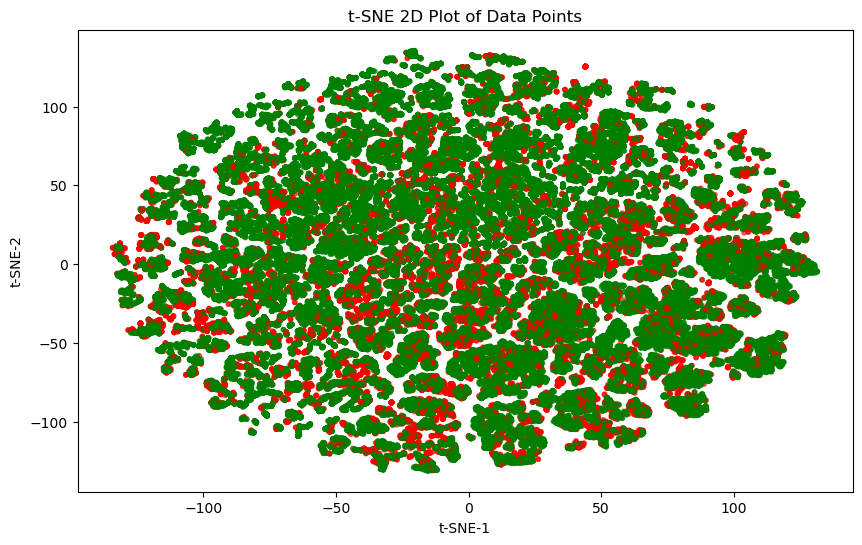

In [ ]:


# Plot the t-SNE results
plt.figure(figsize=(10, 6))
colors = df['LOF_Score'].map({1: 'green', -1: 'red'})  # Map inliers to green, outliers to red
plt.scatter(df['t-SNE-1'], df['t-SNE-2'], c=colors, alpha=0.6, s=10)
plt.title('t-SNE 2D Plot of Data Points')
plt.xlabel('t-SNE-1')
plt.ylabel('t-SNE-2')
plt.show()

In [13]:
%%time
# Scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(columns=['LOF_Score', 't-SNE-1', 't-SNE-2']))

# Initialize the IsolationForest model
isolation_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

# Fit the model to the data
outlier_predictions = isolation_forest.fit_predict(df_scaled)

# Add the outlier predictions as a new column in the dataframe
df['ISF_Score'] = outlier_predictions

# Display the counts of inliers (1) and outliers (-1)
print(df['ISF_Score'].value_counts())

ISF_Score
 1    134578
-1     14953
Name: count, dtype: int64
CPU times: total: 2.75 s
Wall time: 3.31 s


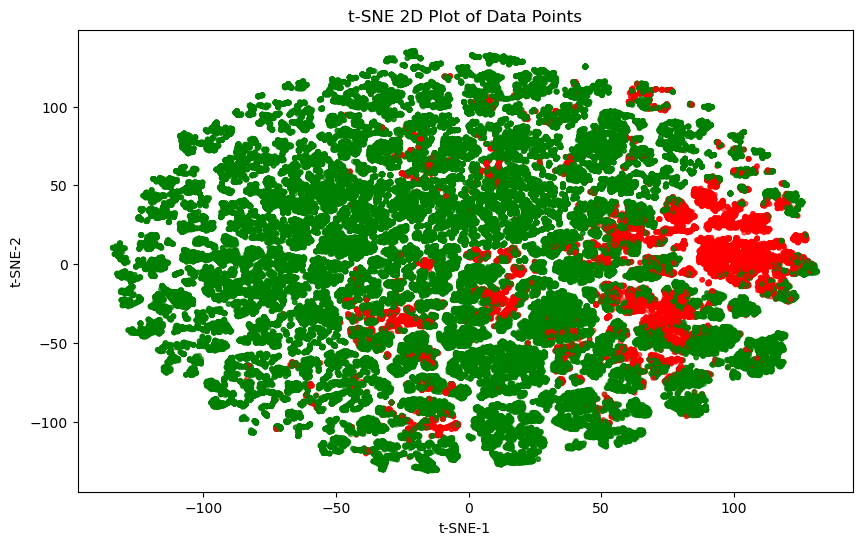

In [17]:
# Plot the t-SNE results
plt.figure(figsize=(10, 6))
colors = df['ISF_Score'].map({1: 'green', -1: 'red'})  # Map inliers to green, outliers to red
plt.scatter(df['t-SNE-1'], df['t-SNE-2'], c=colors, alpha=0.6, s=10)
plt.title('t-SNE 2D Plot of Data Points')
plt.xlabel('t-SNE-1')
plt.ylabel('t-SNE-2')
plt.show()

In [18]:
%%time
# Select only numerical columns from the dataframe and ensure they are numeric
numerical_df = df.select_dtypes(include=['number']).apply(pd.to_numeric, errors='coerce')
numerical_df = numerical_df.drop(columns=['LOF_Score', 'ISF_Score', 't-SNE-1', 't-SNE-2'], errors='ignore')

# Drop rows with NaN values (if any) after conversion
numerical_df = numerical_df.dropna()

# normalizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numerical_df)

# Initialize the ABOD model
abod = ABOD(n_neighbors=50, method="fast", contamination=0.1)

# Fit the model to the numerical data
abod.fit(X_scaled)

# Predict the outliers based on decision scores
outlier_predictions = abod.decision_function(numerical_df)

# Sort the decision scores to identify the top 1% as outliers
threshold = sorted(outlier_predictions)[int(len(outlier_predictions) * 0.90)]

# Label outliers as -1 and inliers as 1 based on the threshold
df['ABOD_Score'] = [-1 if score >= threshold else 1 for score in outlier_predictions]

# Display the counts of inliers (1) and outliers (-1)
print(df['ABOD_Score'].value_counts())

ABOD_Score
 1    134577
-1     14954
Name: count, dtype: int64
CPU times: total: 2h 17min 13s
Wall time: 2h 26min 24s


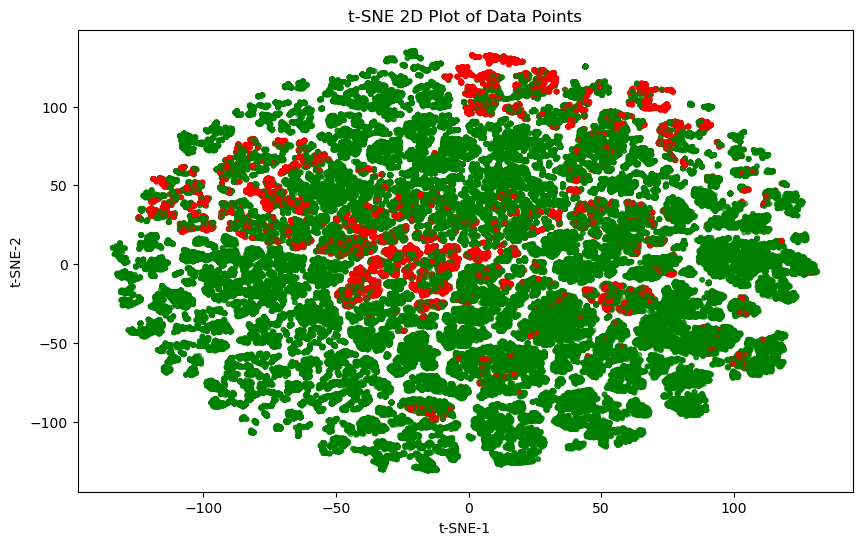

In [19]:
# Plot the t-SNE results
plt.figure(figsize=(10, 6))
colors = df['ABOD_Score'].map({1: 'green', -1: 'red'})  # Map inliers to green, outliers to red
plt.scatter(df['t-SNE-1'], df['t-SNE-2'], c=colors, alpha=0.6, s=10)
plt.title('t-SNE 2D Plot of Data Points')
plt.xlabel('t-SNE-1')
plt.ylabel('t-SNE-2')
plt.show()

In [23]:
# summing the outlier scores from all three methods
df['common_outlier'] = df['LOF_Score'] + df['ISF_Score'] + df['ABOD_Score']
print(df['common_outlier'].value_counts())

common_outlier
 3    109449
 1     35463
-1      4460
-3       159
Name: count, dtype: int64


In [24]:
df.to_csv('imdb_with_outliers.csv', index=False)

In [ ]:
#dropping rows where outlier score is -3 and -1
df = df[df['common_outlier'] != -3]
df = df[df['common_outlier'] != -1]
df.drop(columns=['LOF_Score', 'ISF_Score', 'ABOD_Score', 'common_outlier', 't-SNE-1', 't-SNE-2'], inplace=True)
df.to_csv('imdb_cleaned.csv', index=False)